## Optimizing Hyperparameters for the VGG16 Model

This following notebook highlights the steps taken to tune the learning rate and beta1 hyperparameter of the Adam optimizer using bayesian optimization with the Ax package. The final optimized model was saved and then compared against other models in a manual inspection. 

**NOTE:** This notebook was run on Kaggle with the GPU Accelator Enabled. The data used for this notebook is available on the MDS-Capstone-GDLR OneDrive. You can find the data used in this notebook by navigating to the Data Processed Ultrasound directory and downloading the data_split_mapped sub-directory.

### Imports

In [1]:
pwd

'/kaggle/working'

In [2]:
!pip3 install ax-platform 

     |████████████████████████████████| 704 kB 4.6 MB/s 
     |████████████████████████████████| 395 kB 9.3 MB/s 
     |████████████████████████████████| 492 kB 9.3 MB/s 
     |████████████████████████████████| 804.1 MB 1.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.3.0 requires torch<1.8,>=1.7.0, but you have torch 1.8.1 which is incompatible.


In [3]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN

In [4]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 3.1 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [5]:
import torch
import numpy as np
import pandas as pd
import os

from torchvision import models, datasets, utils#,transforms
from collections import OrderedDict

from torch import nn, optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

In [6]:
torch.manual_seed(2020)
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

In [7]:
IMAGE_SIZE = 300
BATCH_SIZE = 8

#TRAIN_DIR = "../input/lipodata4/data_split_unmapped/train"
#VALID_DIR = "../input/lipodata4/data_split_unmapped/val"
#TEST_DIR = "../input/lipodata4/data_split_unmapped/test"

TRAIN_DIR = '../input/lipodata/data_split_unmapped/train'
VALID_DIR = '../input/lipodata/data_split_unmapped/val'
TEST_DIR = '../input/lipodata/data_split_unmapped/test'


train_transforms = A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0, 1.0)),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        ToTensorV2(),
        
    ]
)

valid_transforms = A.Compose(
    [
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

In [8]:
class LipoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        
        # Create a list of filepaths of images and the respective label
        self.samples = []

        for i in os.listdir(root_dir):
            if i in ["positive", 'negative']:
                folder = os.path.join(root_dir, i)
                target = folder.split("/")[-1]
                for label in os.listdir(folder):
                    filepath = os.path.join(folder, label)
                    self.samples.append((target, filepath))


    def __len__(self):
        # Get the length of the samples 
        return len(self.samples)

    def __getitem__(self, index):
        # Implement logic to get an image and its label using the received index.
        #
        # `image` should be a NumPy array with the shape [height, width, num_channels].
        # If an image contains three color channels, it should use an RGB color scheme.
        #
        # `label` should be an integer in the range [0, model.num_classes - 1] where `model.num_classes`
        # is a value set in the `search.yaml` file.
        
        # get the filepath of the image based on the index and convert it to 
        # color scale and then into a numpy array
        image = np.array(Image.open(self.samples[index][1]).convert("RGB"))

        # maps a label to an integer value
        label_to_int = {"positive": 1, "negative": 0}
        label = label_to_int[self.samples[index][0]]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
            image = image/255

        return image, label

In [9]:
# test if the above class works and outputs the appropriate info
if __name__ == '__main__':
    dataset = LipoDataset(TRAIN_DIR)
    print(len(dataset))
    print(dataset[0][0].shape)

246
(385, 429, 3)


In [10]:
# create a dataset and tranform the images 
dataset = LipoDataset(TRAIN_DIR, transform=train_transforms)
v_dataset = LipoDataset(VALID_DIR, transform=valid_transforms)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(v_dataset, batch_size=8)

test_dataset = LipoDataset(TEST_DIR, transform=valid_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

img, label = next(iter(train_loader))
img.shape

torch.Size([8, 3, 300, 300])

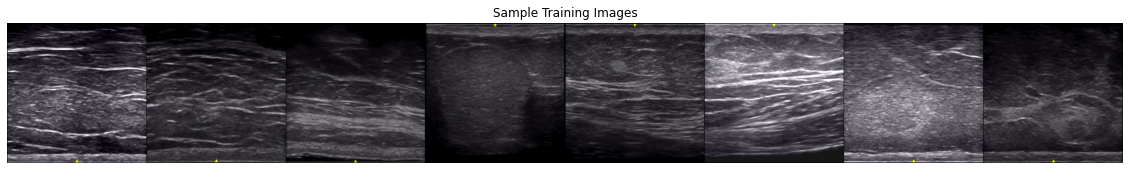

In [11]:
import matplotlib.pyplot as plt
# plot the samples
plt.figure(figsize=(20, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(img, padding=1),(1, 2, 0)));

## Training Functions

In [12]:
def weights_init(m, verbose = False):
    """Initialize weights of each layer to make the results more reproducible"""
    if isinstance(m, nn.Conv2d):
        if verbose:
            print("Initializing weights of a Conv2d layer!")
        nn.init.normal_(m.weight, mean=0, std=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d): 
        if verbose:        
            print("Initializing weights of a batchnorm layer!")
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        if verbose:
            print("Initializing weights of a Linear layer!")
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [13]:
def make_model():
    vgg16 = models.vgg16_bn(pretrained=True)
    
    # Freeze training for all layers
    for param in vgg16.features.parameters():
        param.require_grad = False
        
    # Newly created modules have require_grad=True by default
    num_features = vgg16.classifier[6].in_features
    features = list(vgg16.classifier.children())[:-1] # Remove last layer
    features.extend([nn.Linear(num_features, 1)]) # Add our layer with 4 outputs
    vgg16.classifier = nn.Sequential(*features) 
    
    torch.manual_seed(2020)
    vgg16.apply(weights_init);
    return vgg16

In [14]:
def train(model, train_loader, hyperparameters, epochs=20):
    """Training wrapper for PyTorch network."""

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=hyperparameters.get("lr", 0.001),
                           betas=(hyperparameters.get("beta1", 0.9), 0.999))
    for epoch in range(epochs):
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device, torch.float32), y.to(device, torch.float32)
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            loss = criterion(y_hat, y.type(torch.float32))
            loss.backward()
            optimizer.step()
    
    return model

In [15]:
def evaluate(model, valid_loader):
    """Validation wrapper for PyTorch network."""
    
    model.eval()
    accuracy = 0
    with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
        for X, y in valid_loader:
            if device.type == 'cuda':
                X, y = X.to(device, torch.float32), y.to(device, torch.float32)
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            accuracy += (y_hat_labels == y).type(torch.float32).sum().item()
    accuracy /= len(valid_loader.dataset)  # avg accuracy
    print(f"Validation accuracy: {accuracy:.4f}")
    
    return accuracy 

## Train & Evaluate

In [16]:
def train_evaluate(parameterization):
    model = make_model()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model = train(model, train_loader, hyperparameters=parameterization, epochs=20)
    return evaluate(model, valid_loader)

In [17]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True, "value_type": 'float'},
        {"name": "beta1", "type": "range", "bounds": [0.5, 0.999], "value_type": 'float'},
    ],
    evaluation_function=train_evaluate,
    objective_name='accuracy',
    total_trials = 15
)

[INFO 06-03 06:44:15] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 06-03 06:44:15] ax.service.managed_loop: Started full optimization with 15 steps.
[INFO 06-03 06:44:15] ax.service.managed_loop: Running optimization trial 1...
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[INFO 06-03 06:46:30] ax.service.managed_loop: Running optimization trial 2...


Validation accuracy: 0.6226


[INFO 06-03 06:48:26] ax.service.managed_loop: Running optimization trial 3...


Validation accuracy: 0.6226


[INFO 06-03 06:50:21] ax.service.managed_loop: Running optimization trial 4...


Validation accuracy: 0.6226


[INFO 06-03 06:52:16] ax.service.managed_loop: Running optimization trial 5...


Validation accuracy: 0.7170


[INFO 06-03 06:54:12] ax.service.managed_loop: Running optimization trial 6...


Validation accuracy: 0.6226


[INFO 06-03 06:56:08] ax.service.managed_loop: Running optimization trial 7...


Validation accuracy: 0.7358


[INFO 06-03 06:58:03] ax.service.managed_loop: Running optimization trial 8...


Validation accuracy: 0.7358


[INFO 06-03 06:59:59] ax.service.managed_loop: Running optimization trial 9...


Validation accuracy: 0.7358


[INFO 06-03 07:01:55] ax.service.managed_loop: Running optimization trial 10...


Validation accuracy: 0.6792


[INFO 06-03 07:03:51] ax.service.managed_loop: Running optimization trial 11...


Validation accuracy: 0.7170


[INFO 06-03 07:05:47] ax.service.managed_loop: Running optimization trial 12...


Validation accuracy: 0.6792


[INFO 06-03 07:07:43] ax.service.managed_loop: Running optimization trial 13...


Validation accuracy: 0.7170


[INFO 06-03 07:09:39] ax.service.managed_loop: Running optimization trial 14...


Validation accuracy: 0.6792


[INFO 06-03 07:11:34] ax.service.managed_loop: Running optimization trial 15...


Validation accuracy: 0.6981
Validation accuracy: 0.7925


In [18]:
best_parameters

{'lr': 5.808510479938937e-06, 'beta1': 0.9176069541066801}

In [19]:
means, covariances = values
means, covariances

({'accuracy': 0.7172967886979704},
 {'accuracy': {'accuracy': 0.00013007065356016173}})

In [20]:
data = experiment.fetch_data()
df = data.df
best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='14_0', parameters={'lr': 1.3239393810379851e-05, 'beta1': 0.5})

# Viz

In [21]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

In [22]:
data = experiment.fetch_data()
df = data.df
best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='14_0', parameters={'lr': 1.3239393810379851e-05, 'beta1': 0.5})

In [23]:
df

,arm_name,metric_name,mean,sem,trial_index
0,0_0,accuracy,0.622642,NaN,0
1,1_0,accuracy,0.622642,NaN,1
2,2_0,accuracy,0.622642,NaN,2
3,3_0,accuracy,0.716981,NaN,3
4,4_0,accuracy,0.622642,NaN,4
5,5_0,accuracy,0.735849,NaN,5
6,6_0,accuracy,0.735849,NaN,6
7,7_0,accuracy,0.735849,NaN,7
8,8_0,accuracy,0.679245,NaN,8
9,9_0,accuracy,0.716981,NaN,9


# Testing Functions

In [24]:
def pytorch_confusion_matrix(cnn, data_loader):
    """return confusion matrix on a holdout sample for a pytorch cnn model(binary classification)"""
    confusion_matrix = torch.zeros(2, 2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cnn.eval()
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = cnn(inputs).flatten()
            preds = torch.sigmoid(outputs) > 0.5
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    cm = pd.DataFrame(confusion_matrix.numpy(), columns = ['predict negative','predict positive'], index = ['actual negative', 'actual positive'])
    return cm

def recall_calculation(confusion_matrix):
    """return recall of holdout sample from a confusion matrix"""
    test_recall = confusion_matrix.iloc[1,1]/(confusion_matrix.iloc[1,1]+confusion_matrix.iloc[1,0])
    print(f"Test recall is {test_recall*100:.2f}%.")
    return test_recall

def get_test_accuracy(cnn, data_loader):
    """return accuracy on a holdout sample for a pytorch cnn model"""
    test_batch_acc = 0
    cnn.eval()
    with torch.no_grad():
        for X, y in data_loader:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            y_hat = cnn(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            test_batch_acc += (y_hat_labels == y).type(torch.float32).sum().item()
    test_accuracy = test_batch_acc / len(data_loader.dataset)
    print(f"Test accuracy is {test_accuracy*100:.2f}%.")
    return test_accuracy

## Test

In [25]:
criterion = nn.BCEWithLogitsLoss()
betas = (best_parameters["beta1"], 0.999)
model = make_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
model = train(model, train_loader, hyperparameters=best_arm.parameters, epochs=25)

In [26]:
get_test_accuracy(model, test_loader)

Test accuracy is 70.37%.


0.7037037037037037

In [27]:
pytorch_confusion_matrix(model, test_loader)

,predict negative,predict positive
actual negative,31.0,2.0
actual positive,14.0,7.0


In [28]:
recall_calculation(pytorch_confusion_matrix(model, test_loader))

Test recall is 33.33%.


0.33333334

## Save Model

In [29]:
torch.save(model.state_dict(), 'vgg16-final.pth')